This project leverages Generative Adversarial Networks(GANS) to generate 7,000-10,00 images in the style of Claude Monet. The generator creates Monet-like images, while the discriminator learns to distinguish real from generated works. Our initial EDA focuses on identyfing the defining features of Monet's paintings, such as color palettes, textures and composition to guide model training. We use a CycleGAN since it excels in unpaired image-to-image translation, making it ideal for learning Monet's style without requiring one-to-one mappings between photos and paintings. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# Load in the data

We want to keep our photo dataset and our Monet dataset separate. First, load in the filenames of the TFRecords.

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image


In [5]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def to_display_range(images):
    return (images + 1.0) / 2.0


# Exploratory Data Analysis (EDA)

In [6]:
# Take 100 images for EDA
monet_ds = load_dataset(MONET_FILENAMES).take(100).batch(100)
photo_ds = load_dataset(PHOTO_FILENAMES).take(100).batch(100)

# Convert to numpy arrays in [0, 1] range
monet_images = to_display_range(next(iter(monet_ds))).numpy()
photo_images = to_display_range(next(iter(photo_ds))).numpy()


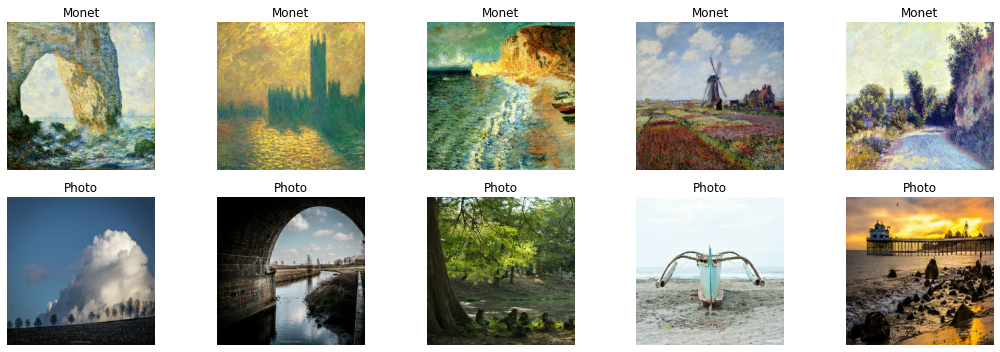

In [7]:
def show_images(monet, photo, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(monet[i])
        plt.title("Monet")
        plt.axis("off")
        
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(photo[i])
        plt.title("Photo")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_images(monet_images, photo_images)


In this next phase of EDA, we aim to establish the defining characteristics of Monet and non-Monet paintings. This not only helps validate the quality and separability of our dataset but also deepens our understanding of what makes Monet’s work unique, which supports both the modeling process and the broader public good.

In [8]:
def plot_pixel_intensity_kde(monet_images, photo_images):
    import seaborn as sns

    monet_flat = monet_images.reshape(-1, 3)
    photo_flat = photo_images.reshape(-1, 3)
    
    colors = ['red', 'green', 'blue']
    channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']
    
    plt.figure(figsize=(18, 4))
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        sns.kdeplot(monet_flat[:, i], label='Monet', color='mediumorchid', linewidth=2)
        sns.kdeplot(photo_flat[:, i], label='Photo', color='deepskyblue', linewidth=2, linestyle='--')
        
        plt.title(channel_names[i])
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Density")
        plt.legend(frameon=False)
        plt.box(False)
    
    plt.tight_layout()
    plt.show()


In [9]:
def plot_hsv_kde(monet_hsv, photo_hsv):
    import seaborn as sns

    monet_flat = monet_hsv.reshape(-1, 3)
    photo_flat = photo_hsv.reshape(-1, 3)
    
    hsv_names = ['Hue', 'Saturation', 'Value']
    colors = ['darkorange', 'limegreen', 'dodgerblue']
    
    plt.figure(figsize=(18, 4))
    
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        sns.kdeplot(monet_flat[:, i], label='Monet', color=colors[i], linewidth=2)
        sns.kdeplot(photo_flat[:, i], label='Photo', color=colors[i], linestyle='--', linewidth=2)
        
        plt.title(hsv_names[i])
        plt.xlabel(hsv_names[i])
        plt.ylabel("Density")
        plt.legend(frameon=False)
        plt.box(False)

    plt.tight_layout()
    plt.show()


In [10]:
import cv2
import seaborn as sns

def compute_laplacian_variance(images):
    variances = []
    for img in images:
        # Convert RGB to grayscale
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        variance = laplacian.var()
        variances.append(variance)
    return variances


In [11]:
def plot_laplacian_variance_kde(monet_images, photo_images):
    import seaborn as sns

    monet_lap_var = compute_laplacian_variance(monet_images)
    photo_lap_var = compute_laplacian_variance(photo_images)

    plt.figure(figsize=(6, 4))
    
    sns.kdeplot(monet_lap_var, label="Monet", color="crimson", linewidth=2)
    sns.kdeplot(photo_lap_var, label="Photo", color="steelblue", linestyle="--", linewidth=2)
    
    plt.title("Laplacian Variance (Texture)")
    plt.xlabel("Variance of Laplacian")
    plt.ylabel("Density")
    plt.legend(frameon=False)
    plt.box(False)
    plt.tight_layout()
    plt.show()


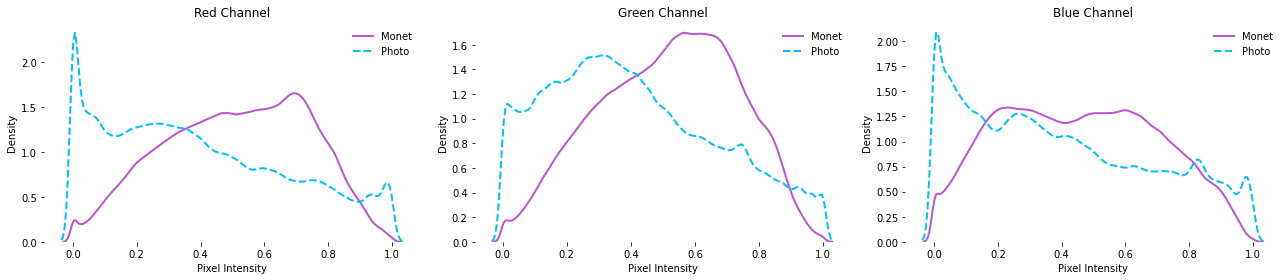

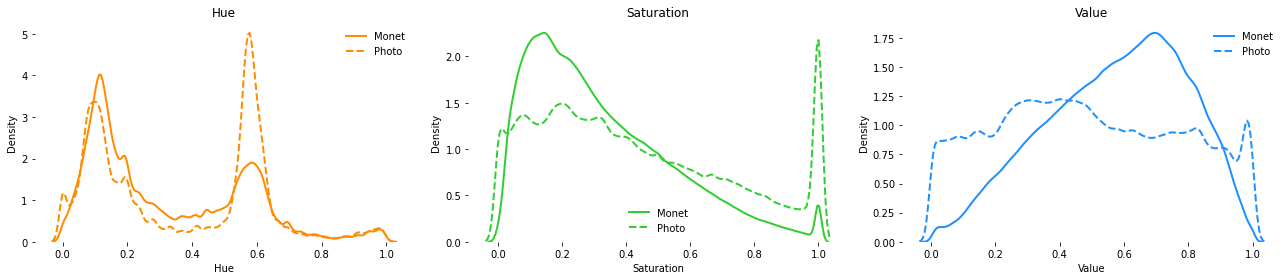

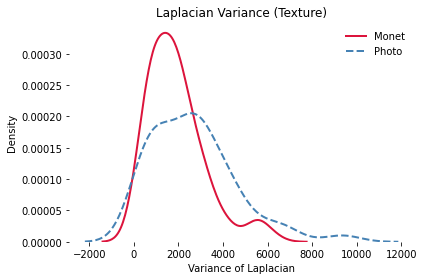

In [12]:
# Pixel intensity
plot_pixel_intensity_kde(monet_images, photo_images)

# HSV
monet_hsv = tf.image.rgb_to_hsv(monet_images).numpy()
photo_hsv = tf.image.rgb_to_hsv(photo_images).numpy()
plot_hsv_kde(monet_hsv, photo_hsv)

# Texture
plot_laplacian_variance_kde(monet_images, photo_images)

**Monet paintings are defined by soft blended colors, moderate saturation, and smooth abstract textures, while photo images feature sharper contrasts, vivid saturation, and clearly defined structural details.**

Monet paintings have soft and blended pixel intensity across RGB channels
The distributions are smooth and mid-range, indicating an impressionist style with fewer dark shadows and more diffuse color transitions.

Monet hue values cluster around warm and cool tones
Peaks around 0.1 and 0.5 suggest a dominance of oranges/yellows and blues/purples, consistent with Monet's natural and atmospheric palette.

Monet images use moderate saturation without extremes
The saturation curve avoids the sharp peak near 1.0, reflecting a deliberate use of color that feels vivid yet muted and harmonious.

Monet brightness values are gently spread out
The value distribution shows a more organic range of light and dark, relying on color interplay rather than stark lighting contrasts.

Monet textures have low Laplacian variance
The brushstroke style creates smooth transitions and lower edge detail, which aligns with the artistic abstraction of forms in impressionist art.

Photo images show sharper contrast and deeper shadows
The pixel intensity curves are skewed toward 0.0, revealing high black-point presence and sharper tonal differences.

Photo hue distributions are more concentrated and structured
The peaks suggest real-world lighting and object color fidelity, unlike the painterly variation in Monet images.

Photo saturation often peaks near full intensity
This indicates highly saturated regions such as reflective surfaces or artificial lighting, which are typical in photographs.

Photo brightness values are more centered and uniform
The value curve shows consistent illumination, possibly due to evenly lit outdoor or indoor photography conditions.

Photo textures have high Laplacian variance
The high-frequency edge content reflects structural clarity, detailed objects, and the natural sharpness of camera-captured scenes.

Now we have a clear understanding of what the generator must learn and what the discriminator is trained to detect. The better our generator becomes at mimicking these subtle artistic cues, the more effectively it can fool the discriminator and the closer we are to recreating the essence of Monet’s style. Because we’ve identified these distinguishing characteristics, we can now analyze them during training to better understand how the model evolves and whether it's truly learning to generate images in the spirit of Monet, not just to minimize loss.

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image.set_shape([256, 256, 3])  
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [ ]:
for monet_img, photo_img in tf.data.Dataset.zip((monet_ds, photo_ds)).take(55):
    print("Monet shape:", monet_img.shape)
    print("Photo shape:", photo_img.shape)


In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's  visualize a photo example and a Monet example.

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Build the generator

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods.

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [ ]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Lambda(lambda x: tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')))
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',  
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


We use reflection padding instead of zero padding to avoid harsh edges and border artifacts. This helps preserve smooth transitions and continuity in the generated images, which is especially important for replicating Monet’s soft, painterly style.


`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Let's build our generator!

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
OUTPUT_CHANNELS = 3

def residual_block(x, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_tensor = x
    x = layers.Lambda(lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT'))(x)
    x = layers.Conv2D(filters, 3, padding='valid', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.ReLU()(x)

    x = layers.Lambda(lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT'))(x)
    x = layers.Conv2D(filters, 3, padding='valid', kernel_initializer=initializer, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)

    return layers.Add()([input_tensor, x])


def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Lambda(lambda x: tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')))
    result.add(layers.Conv2D(filters, size, strides=2, padding='valid',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())
    return result


def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())
    return result


def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  
        downsample(128, 4),  
        downsample(256, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4),  
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4),  
        upsample(256, 4),  
        upsample(128, 4),  
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  

    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    # 6 Residual blocks at 2x2 resolution (before upsampling)
    for _ in range(6):
        x = residual_block(x, filters=512)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


We added reflection padding to reduce edge artifacts and create smoother transitions in the generated images. This helps the model better replicate Monet’s soft, continuous painting style, especially around image borders where zero padding can introduce unnatural sharpness.

# Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)   
    down2 = downsample(128, 4)(down1)     
    down3 = downsample(256, 4)(down2)    

    # Replace ZeroPadding2D with reflection padding
    x = layers.Lambda(lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT'))(down3) 
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)      
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Lambda(lambda x: tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], mode='REFLECT'))(x)      
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)                     

    return tf.keras.Model(inputs=inp, outputs=last)


We replaced zero padding with reflection padding in the discriminator to maintain consistency with the generator and reduce border artifacts. Reflection padding helps the discriminator focus on meaningful texture and edge patterns rather than artificial padding boundaries.


In [ ]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [ ]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

The modified generator produces more meaningful early outputs with soft color transitions and structural hints, showing that reflection padding and residual blocks help the model better capture Monet’s style.


# Build the CycleGAN model

We will subclass a `tf.keras.Model` so that we can run `fit()` later to train our model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

The losses are defined in the next section.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Define loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model.

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

The loss output shows an early plateau, indicating limited learning progress. To address this, we apply a learnign rate scheduler in the code below to gradually reduce the learnign rate and encourage continued convergence.

In [ ]:
# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2e-4,
    decay_steps=300 * 5,  
    decay_rate=0.9,
    staircase=True
)

# Optimizers with learning rate schedule
monet_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
monet_disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.5)

# Cycle consistency loss
def cycle_loss(real_image, cycled_image, lambda_cycle):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))
# Identity loss
def identity_loss(real_image, same_image, lambda_cycle):
    return 0.5 * lambda_cycle * tf.reduce_mean(tf.abs(real_image - same_image))

# Compile the model
cycle_gan_model.compile(
    m_gen_optimizer=monet_gen_optimizer,
    p_gen_optimizer=photo_gen_optimizer,
    m_disc_optimizer=monet_disc_optimizer,
    p_disc_optimizer=photo_disc_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)

In [ ]:
class DualLossEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, min_delta=0.001):
        super().__init__()
        self.patience = patience
        self.min_delta = min_delta
        self.best_gen_loss = float('inf')
        self.best_disc_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        gen_loss = logs.get("monet_gen_loss")
        disc_loss = logs.get("monet_disc_loss")

        if gen_loss is None or disc_loss is None:
            return

        gen_loss = float(tf.reduce_mean(gen_loss).numpy())
        disc_loss = float(tf.reduce_mean(disc_loss).numpy())


        gen_improved = (self.best_gen_loss - gen_loss) > self.min_delta

        if gen_improved:
            self.best_gen_loss = gen_loss
            self.best_disc_loss = disc_loss
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience:
            print(f"\nEarly stopping at epoch {epoch + 1}: "
              f"monet_gen_loss={gen_loss:.4f}, monet_disc_loss={disc_loss:.4f}")
            self.model.stop_training = True

In [ ]:
early_stop = DualLossEarlyStopping(patience=5, min_delta=0.001)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
    callbacks=[early_stop]
)

# Visualize our Monet-esque photos

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create submission file

In [ ]:
import PIL
! mkdir ../images

In [ ]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

# References

Amy Jang CycleGAN tutorial [(https://www.kaggle.com/amyjang/monet-cyclegan-tutorial//)]